In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Mall_Customers.csv')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# There are no missing values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# CustomerID is not required for modeling
df = df.drop('CustomerID', axis=1)

In [6]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


### 1. Exploratory Data Analysis (EDA)

Female    0.56
Male      0.44
Name: Gender, dtype: float64


<AxesSubplot:xlabel='Gender', ylabel='count'>

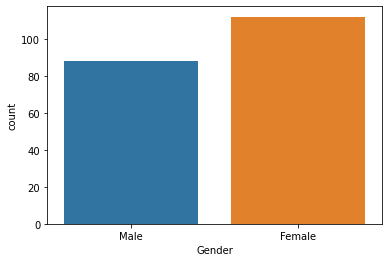

In [7]:
# data is unbaised - equally distributed between men & women
print (df['Gender'].value_counts() / len(df))
sns.countplot(x='Gender',data=df)

<AxesSubplot:xlabel='Age'>

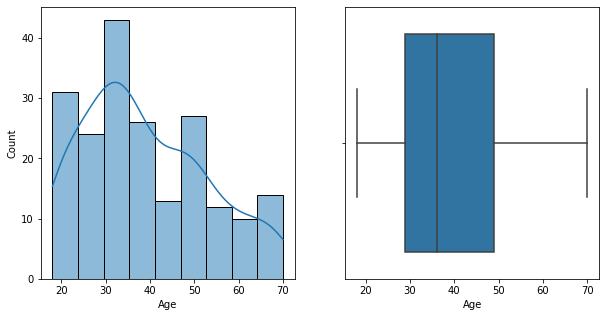

In [8]:
# average age is mid 30s
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Age',data=df, kde=True, ax=axes[0])
sns.boxplot(x='Age',data=df, ax=axes[1])

<AxesSubplot:xlabel='Gender', ylabel='Age'>

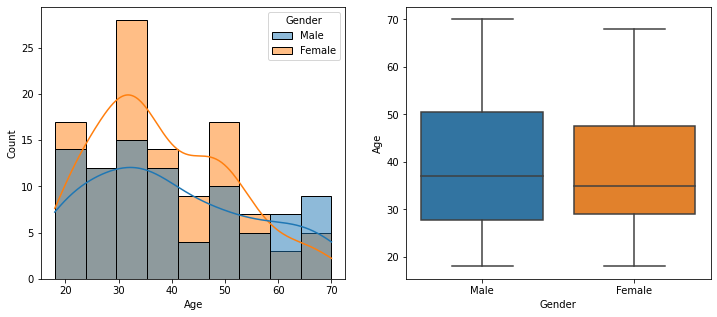

In [9]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(x='Age',data=df, kde=True, hue='Gender', ax=axes[0])
sns.boxplot(x='Gender',data=df, y='Age', ax=axes[1])

<AxesSubplot:xlabel='Annual Income (k$)'>

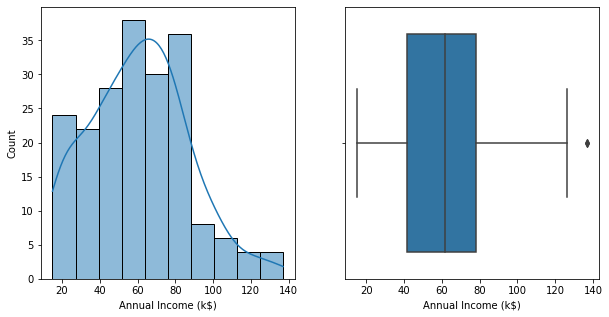

In [10]:
# average income is 60k
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Annual Income (k$)',data=df, kde=True, ax=axes[0])
sns.boxplot(x='Annual Income (k$)',data=df, ax=axes[1])

<AxesSubplot:xlabel='Gender', ylabel='Annual Income (k$)'>

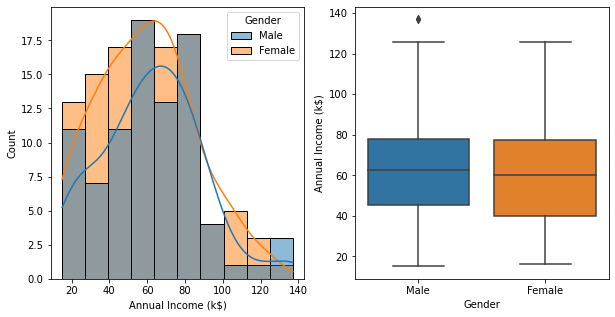

In [11]:
# Higher average annual income for female than males in the dataset
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Annual Income (k$)',data=df, hue='Gender', kde=True, ax=axes[0])
sns.boxplot(y='Annual Income (k$)',data=df, x='Gender',ax=axes[1])

<AxesSubplot:xlabel='Spending Score (1-100)'>

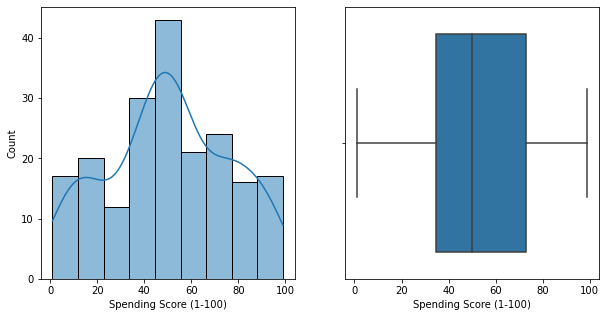

In [12]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Spending Score (1-100)',data=df, kde=True, ax=axes[0])
sns.boxplot(x='Spending Score (1-100)',data=df, ax=axes[1])

<AxesSubplot:xlabel='Gender', ylabel='Spending Score (1-100)'>

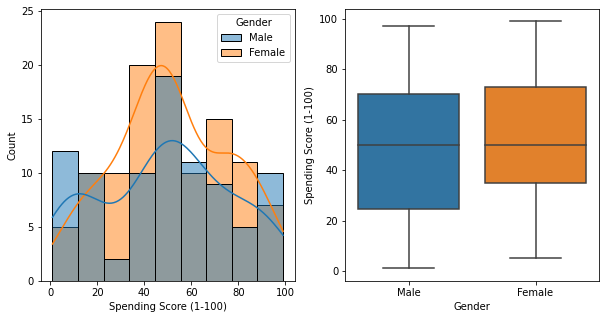

In [13]:
# Higher spending score for females than males 
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(x='Spending Score (1-100)',data=df, hue='Gender', kde=True, ax=axes[0])
sns.boxplot(y='Spending Score (1-100)', x='Gender', data=df, ax=axes[1])

In [14]:
corr = df.corr()
corr

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


<AxesSubplot:>

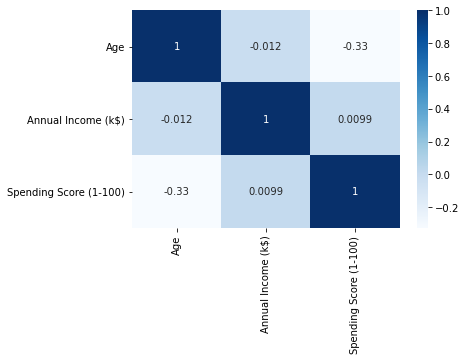

In [15]:
# negative relationship between age and income & spending score
# postive relationship between income and spending score
sns.heatmap(corr, annot=True, cmap='Blues')

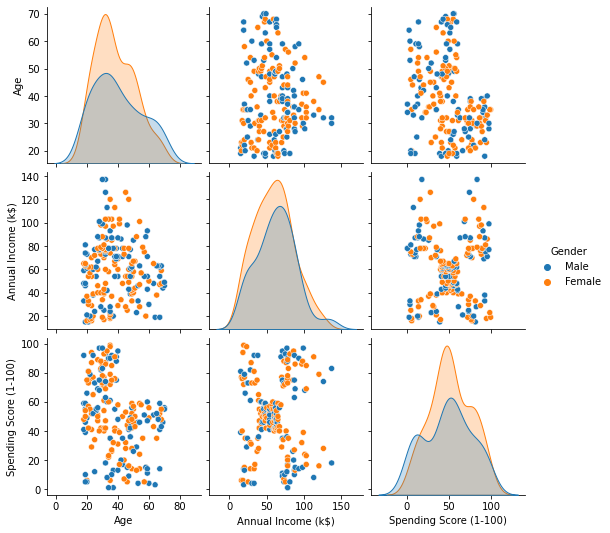

In [16]:
sns.pairplot(data=df, hue='Gender')

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

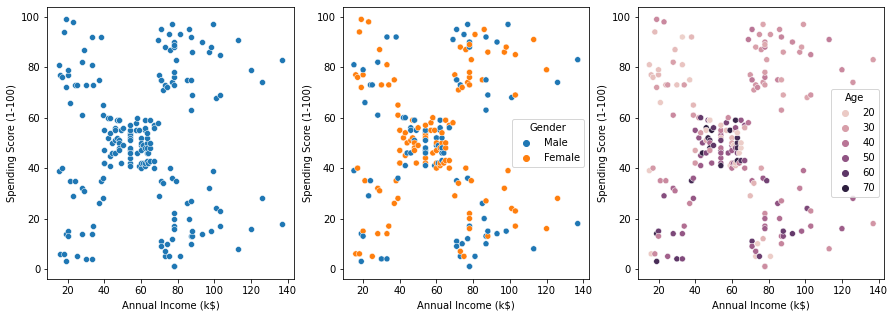

In [17]:
# the data seems to be devided into 5 cluster based on annual income and spending score
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',data=df, ax=axes[0])
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='Gender',data=df, ax=axes[1])
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='Age',data=df, ax=axes[2])

<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

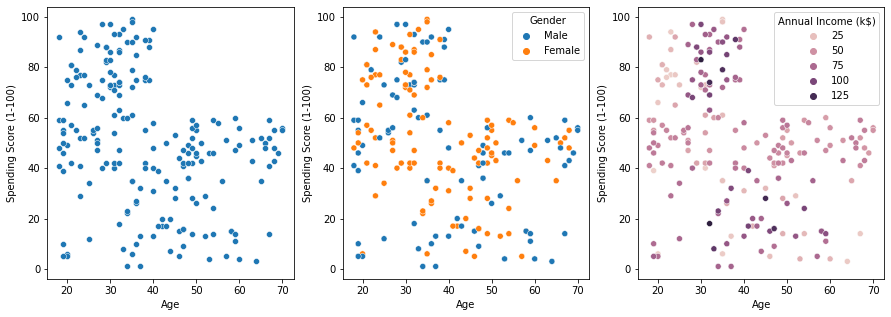

In [18]:
# there is no clear clustering between age and spending score
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.scatterplot(x='Age',y='Spending Score (1-100)',data=df, ax=axes[0])
sns.scatterplot(x='Age',y='Spending Score (1-100)',hue='Gender',data=df, ax=axes[1])
sns.scatterplot(x='Age',y='Spending Score (1-100)',hue='Annual Income (k$)',data=df, ax=axes[2])

### 2. Data Normalization 

In [19]:
df['Gender'] = df['Gender'].map({'Male':1,'Female':0})
scaled_data = StandardScaler().fit_transform(df)

In [20]:
scaled_df = pd.DataFrame(scaled_data, columns = df.columns)
scaled_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


### 3. Hierarchical clustering

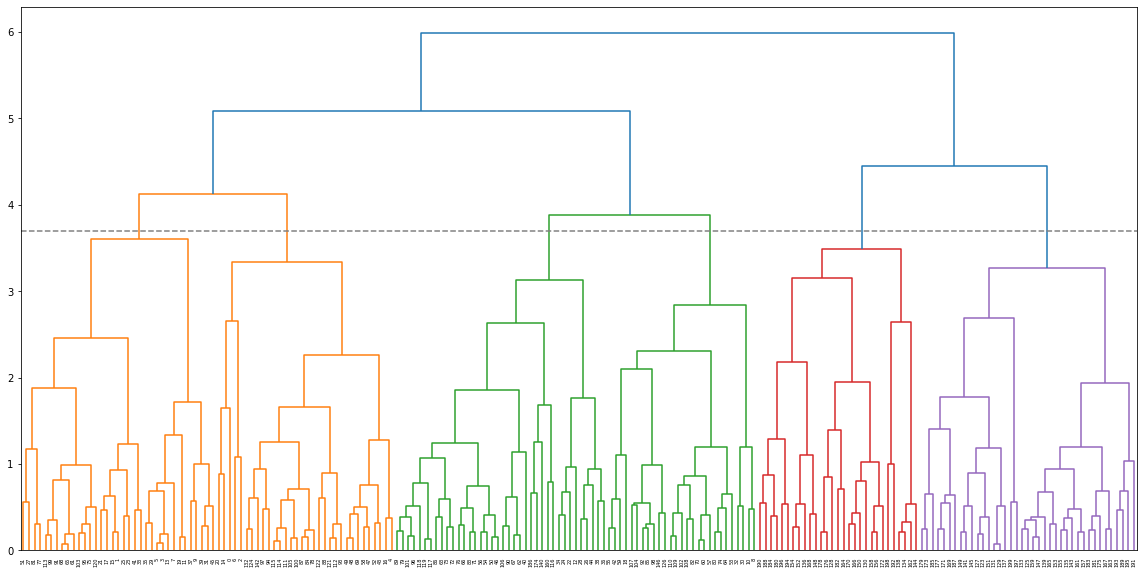

In [21]:
l = linkage(scaled_df, method='complete')

plt.figure(figsize=(20,10))
dendrogram(l,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.axhline(3.7, color='gray', linestyle='--')
plt.show()

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Age'>

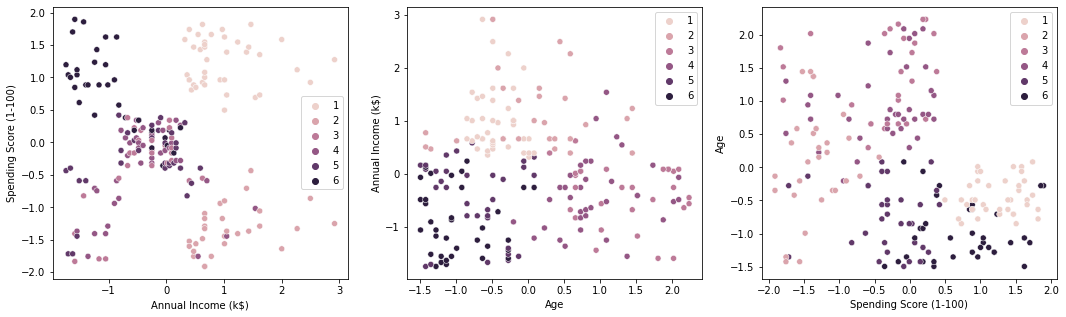

In [22]:
cluster = fcluster(l,6, criterion='maxclust')
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue=cluster,data=scaled_df, ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue=cluster, data=scaled_df, ax=axes[1])
sns.scatterplot(x='Spending Score (1-100)',y='Age',hue=cluster, data=scaled_df, ax=axes[2])
#plt.plot(kmeans.cluster_centers_)

in the first and second charts, we can see almost clear grouping between spending score & annual income and age and annual income. 3rd chart between Age & spending score is not very clear

In [23]:
# Cluster definition 
df1 = df.copy()
df1['cluster'] = cluster
df1 = df1.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df1['pct'] = df1.iloc[:,0] / df1.iloc[:,0].sum() * 100
df1

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
6,35,0.628571,25.228571,69.571429,36.714286,17.5
5,32,0.093750,28.468750,42.250000,48.906250,16.0
1,39,0.461538,32.692308,82.128205,86.538462,19.5
2,29,0.620690,39.620690,15.758621,89.551724,14.5
4,38,0.000000,52.368421,39.394737,51.236842,19.0
3,27,1.000000,57.851852,40.592593,49.740741,13.5


Using hierarchical clustering, we divided the mall customers into 6 groups:
- Young customers in their mid 20s with low annual income (averaging 36k) and above average spending score (62% females)
- Young customers in their late 20s with medium annual income (averaging 48k) and medium spending score (9% females)
- Customers in their early 30s with high annual income (averaging 86k) and high spending score (46% females)
- Customers in their late 30s with high annual income (averaging 89k) and low spending score (62% females)
- Customers in their early 50s with medium annual income (averaging 51k) and relatively low spending score (all females)
- Customers in their mid 50s with medium annual income (averaging 49k) and relatively low spending score (all males)

### 3. K-MEANS Clustering

In [24]:
inertias = []
silhouette_coefficients = []
cluster_num = range(1, 11)
for i in cluster_num:
    kmeans = KMeans(n_clusters = i, random_state=0)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
    if i>1:
        score = silhouette_score(scaled_df,kmeans.labels_)
        silhouette_coefficients.append(score)

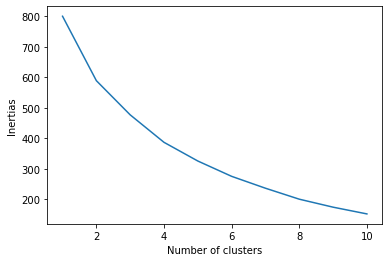

In [25]:
# The Elbow Method - there in no clear cut to decide on the number of clusters
plt.plot(cluster_num, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

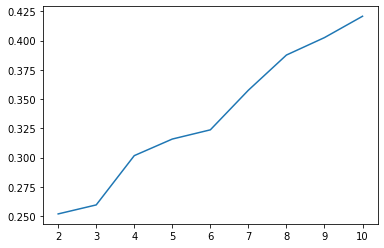

In [26]:
# silhouette coefficients - again no clear breaking point to decide on the number of clusters
plt.plot(range(2, 11), silhouette_coefficients)

In [27]:
# trying to re-do the analysis after excluding gender
X = scaled_df.iloc[:,1:]
inertias = []
silhouette_coefficients = []
cluster_num = range(1, 11)
for i in cluster_num:
    kmeans = KMeans(n_clusters = i, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    if i>1:
        score = silhouette_score(X,kmeans.labels_)
        silhouette_coefficients.append(score)

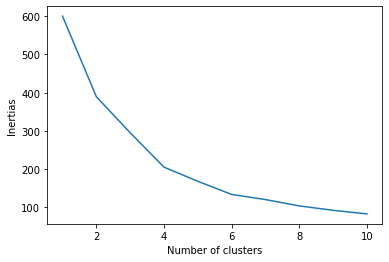

In [28]:
# The Elbow Method - it seems like 6 clusters is ideal number for the analysis
plt.plot(cluster_num, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show()

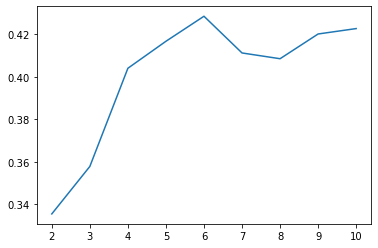

In [29]:
# silhouette coefficients - supports having 6 clusters
plt.plot(range(2, 11), silhouette_coefficients)

In [30]:
kmeans = KMeans(n_clusters = 6)
kmeans.fit_predict(X)
cluster = kmeans.predict(X)

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Age'>

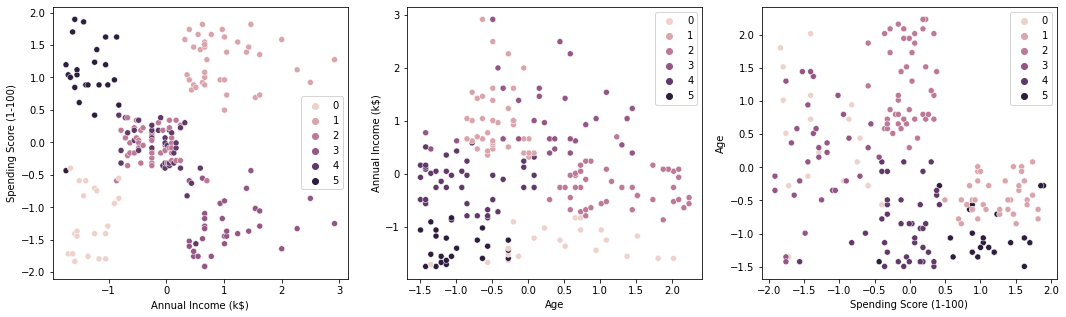

In [31]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue=cluster,data=X, ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue=cluster, data=X, ax=axes[1])
sns.scatterplot(x='Spending Score (1-100)',y='Age',hue=cluster, data=X, ax=axes[2])
#plt.plot(kmeans.cluster_centers_)

The 3 charts show almost clear grouping between spending score & annual income, age & annual income and between Age & spending score - actually the clusters here are more clear than in hierarchal clustering

In [32]:
# Cluster definition 
df2 = df.copy()
df2['cluster'] = cluster
df2 = df2.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df2['pct'] = df2.iloc[:,0] / df2.iloc[:,0].sum() * 100
df2

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
5,23,0.434783,25.000000,77.608696,25.260870,11.5
4,39,0.358974,26.794872,48.128205,57.102564,19.5
1,39,0.461538,32.692308,82.128205,86.538462,19.5
3,33,0.575758,41.939394,16.969697,88.939394,16.5
0,21,0.380952,45.523810,19.380952,26.285714,10.5
2,45,0.422222,56.333333,49.066667,54.266667,22.5


Using hierarchical clustering, we divided the mall customers into 6 groups:
- Young customers in their mid 20s with low annual income (averaging 25k) and high spending score (41% females)
- Young customers in their mid 20s with medium annual income (averaging 47k) and medium spending score (36% females)
- Customers in their early 30s with high annual income (averaging 86k) and high spending score (46% females)
- Customers in their early 40s with high annual income (averaging 89k) and low spending score (57% females)
- Customers in their mid 40s with low annual income (averaging 26k) and low spending score (38% females)
- Customers in their mid 50s with medium annual income (averaging 49k) and medium spending score (42% females)

### 4. DBSCAN Clustering

In [33]:
# decide on the number of clusters
silhouette_coefficients = []
for eps in np.linspace(0.1,1,10):
    for min_samples in  np.linspace(5,25,5,dtype=int):
        dbscan = DBSCAN(eps=eps,min_samples=min_samples)
        dbscan.fit_predict(scaled_df)
        labels = dbscan.labels_
        if (len(np.unique(labels))>3):
            # Number of clusters in labels, ignoring noise if present - only show if number of clusters >=3
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            print (f"clusters: {n_clusters_}, noise: {n_noise_} (eps : {eps:1.2f}, min_samples:{min_samples})")

clusters: 4, noise: 165 (eps : 0.40, min_samples:5)
clusters: 9, noise: 105 (eps : 0.50, min_samples:5)
clusters: 9, noise: 62 (eps : 0.60, min_samples:5)
clusters: 3, noise: 147 (eps : 0.60, min_samples:10)
clusters: 7, noise: 37 (eps : 0.70, min_samples:5)
clusters: 5, noise: 106 (eps : 0.70, min_samples:10)
clusters: 5, noise: 19 (eps : 0.80, min_samples:5)
clusters: 4, noise: 68 (eps : 0.80, min_samples:10)
clusters: 3, noise: 137 (eps : 0.80, min_samples:15)
clusters: 5, noise: 46 (eps : 0.90, min_samples:10)


In [34]:
# minimum noise with 5 clusters at eps =0.8 & min_samples=5
dbscan = DBSCAN(eps=0.8,min_samples=5)
dbscan.fit_predict(scaled_df)
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print (f"clusters: {n_clusters_}, noise: {n_noise_}")

clusters: 5, noise: 19


<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Age'>

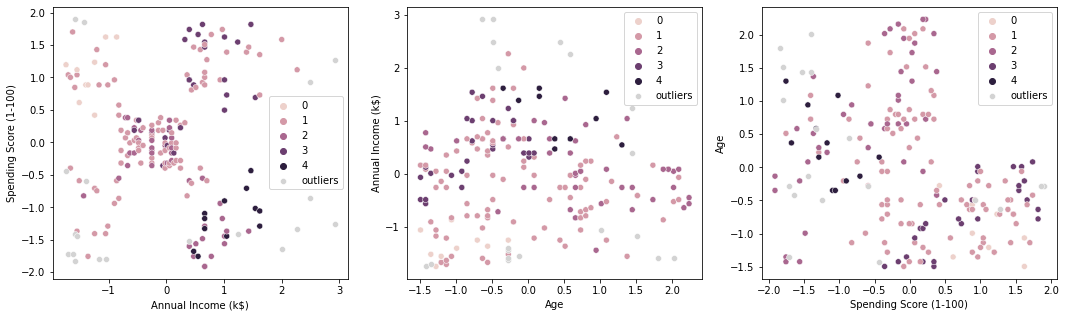

In [35]:
dbscan_df = scaled_df.copy()
dbscan_df['label'] = labels

fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='label',data=dbscan_df[dbscan_df['label']!=-1], ax=axes[0])
sns.scatterplot(x='Age',y='Annual Income (k$)',hue='label', data=dbscan_df[dbscan_df['label']!=-1], ax=axes[1])
sns.scatterplot(x='Spending Score (1-100)',y='Age',hue='label', data=dbscan_df[dbscan_df['label']!=-1], ax=axes[2])

sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',data=dbscan_df[dbscan_df['label']==-1], color='lightgray', ax=axes[0],label='outliers')
sns.scatterplot(x='Age',y='Annual Income (k$)', data=dbscan_df[dbscan_df['label']==-1],color='lightgray', ax=axes[1],label='outliers')
sns.scatterplot(x='Spending Score (1-100)',y='Age', data=dbscan_df[dbscan_df['label']==-1],color='lightgray', ax=axes[2], label='outliers')


In [36]:
# Cluster definition 
df3 = df.copy()
df3['cluster'] = labels
df3 = df3[df3['cluster']!=-1]
df3 = df3.groupby('cluster')[['cluster','Gender','Age','Spending Score (1-100)','Annual Income (k$)']].agg({'cluster':'count','Gender':'mean','Age':'mean','Spending Score (1-100)':'mean','Annual Income (k$)':'mean'}).sort_values(['Age'])
df3['pct'] = df3.iloc[:,0] / df3.iloc[:,0].sum() * 100
df3

,cluster,Gender,Age,Spending Score (1-100),Annual Income (k$),pct
cluster,,,,,,
0,9,1,25.000000,77.666667,25.777778,4.972376
3,26,1,28.961538,71.423077,72.076923,14.364641
1,94,0,37.542553,56.095745,55.893617,51.933702
4,12,0,43.416667,20.416667,88.333333,6.629834
2,40,1,48.625000,34.825000,63.325000,22.099448


Clustring using DBSCAN is dividing males and females:
    
- Males in their mid 20s with low annual income and high spending score
- Males in their late 20s with high annual income and high spending score
- Females in their late 30s with medium annual income and medium spending score 
- Females in their mid 40s with high annual income and low spending score 
- Males in their late 40s with relatively high annual income and relatively low spending score 

### 5. Conclusion 

- The results of hierarchical and KMeans clustering were not far off although we included Gender in the Hierarchical model and excluded it from KMeans
- DBSCAN analysis clearly divided the clusters based on Gender and then factored the other features in the analysis